# This is the First Draft of Our Clustering Final Notebook

In [6]:
# Performing the many imports required to do the various analyses of this notebook:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import scipy.stats as stats

In [7]:
# THE WRANGLE FUNCTION PERFORMS THE FOLLOWING, IN BROAD STROKES:
# 1. Get the data via SQL query
# 2. Clean and prep the data
# 3. Encode the appropriate columns (only ['county'] for now)
# 4. Split the data: train, validate, test and X_ vs y_ splits as well
# 5. Scale the data (all train, validate and test, and all X_ and y_ splits are scaled)

df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, \
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()

# Exploration: univariate

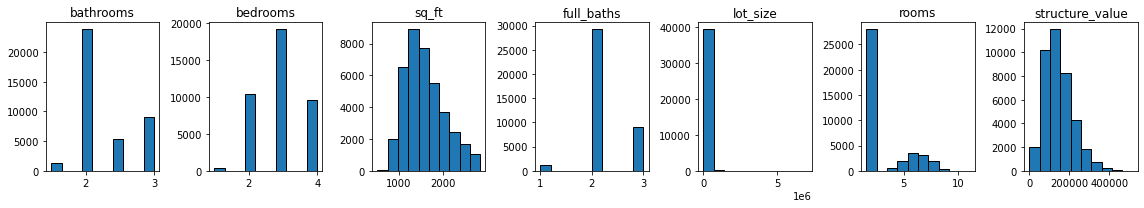

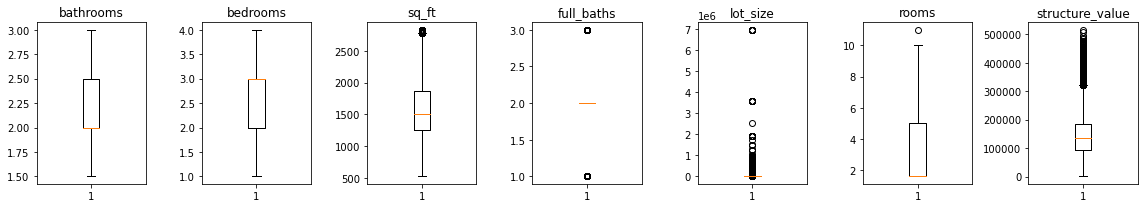

In [9]:
# The following four cells call a function in our viz_explore script to visualize histogrmas and boxplots
# for all the features left in the main dataframe.
viz_explore.histograms1(df)

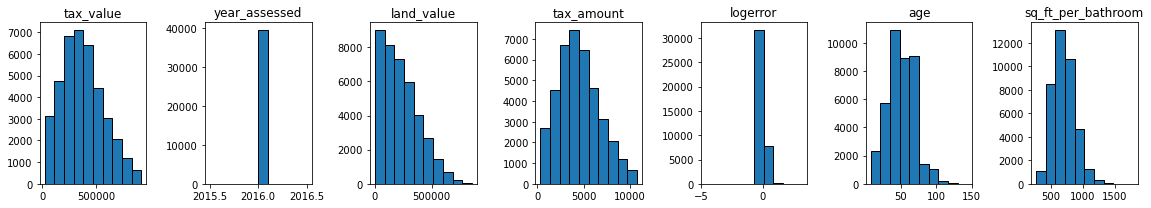

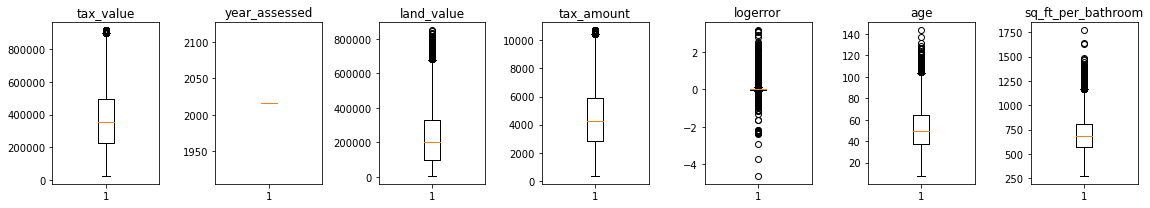

In [10]:
viz_explore.hists2(df)

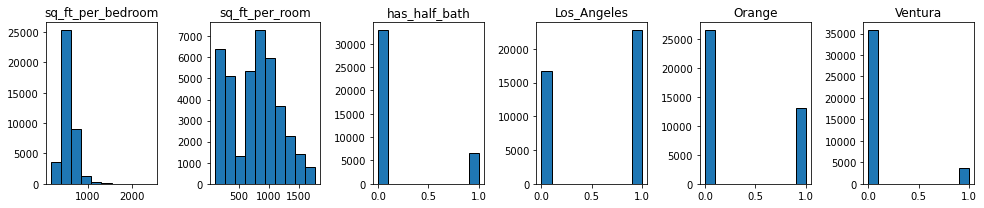

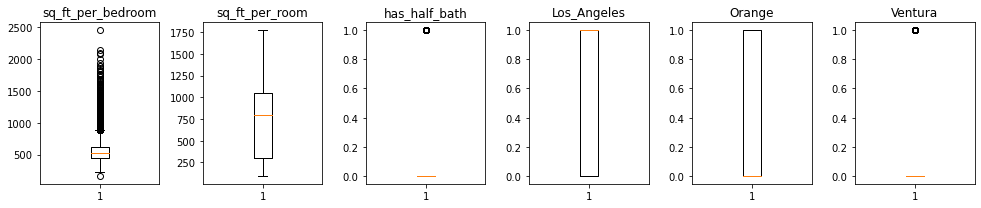

In [11]:
viz_explore.hists3(df)

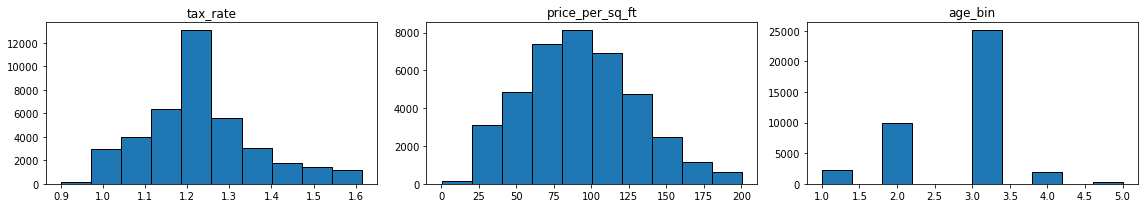

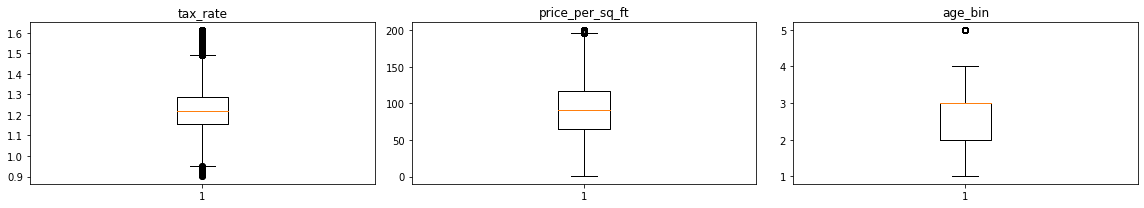

In [12]:
viz_explore.hists4(df)

- The main standouts here are the number of rooms, which has a considerable right skew (also, all homes that had previously had "zero" rooms were imputed to the mean), as well as the many outliers in certain attributes, which have been left even after applying a "remove_outliers" function in the wrangle module.

### Exploration question 1:

### Is there a time period that has a higher or lower log error?

<AxesSubplot:xlabel='age', ylabel='logerror'>

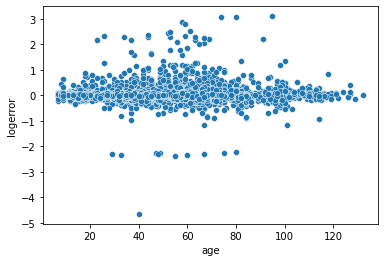

In [13]:
# A seaborn scatterplot comparing age to logerror
sns.scatterplot(x='age', y='logerror', data=train)

- There are a few outliers on logerror in the middle of the ages (less so on the extreme age values). Still, not exactly tons of them, considering the number of rows we have.

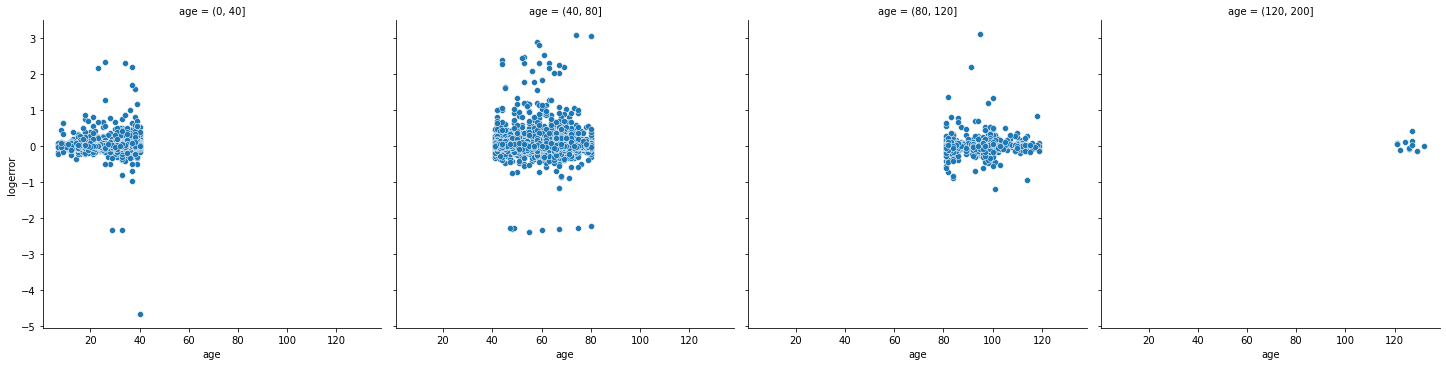

In [18]:
sns.relplot(
    data=train,
    y='logerror',
    x='age',
    col=pd.cut(df.age, bins=[0,40,80,120,200]),
)

Things look a little tighter on either end...the 40-60 and the 60-80 look like they have a wider distribution of logerror

<AxesSubplot:xlabel='age_bin', ylabel='logerror'>

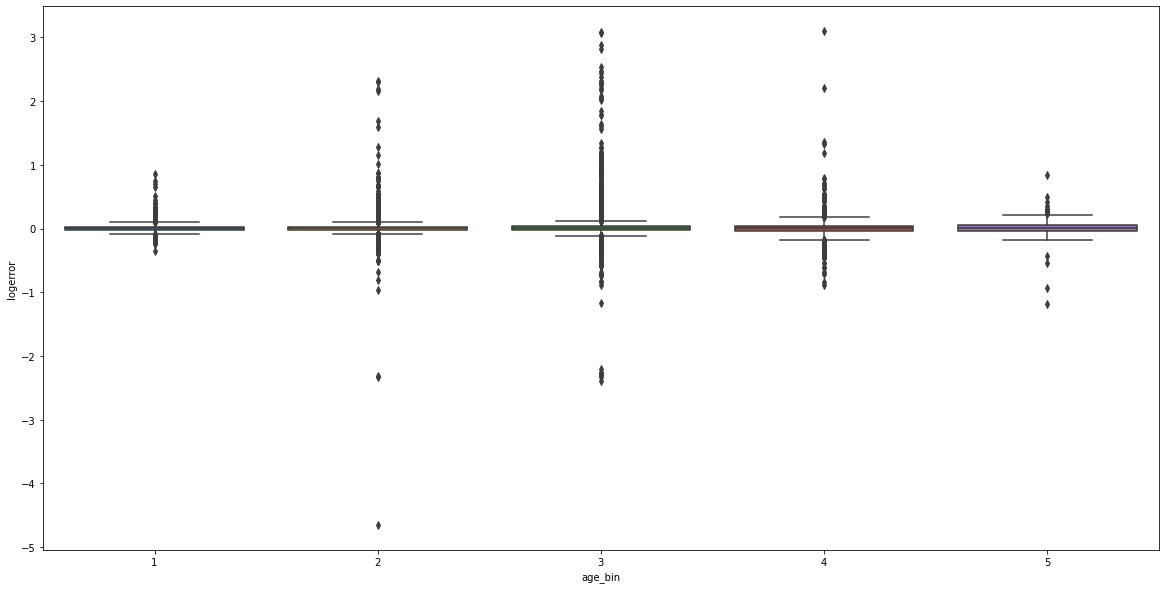

In [19]:
plt.figure(figsize=(20,10))
sns.boxplot(x='age_bin', y='logerror', data= train)

Still looks like there are more outliers in the middle, but this could be due to more data being available in those age bins

<AxesSubplot:>

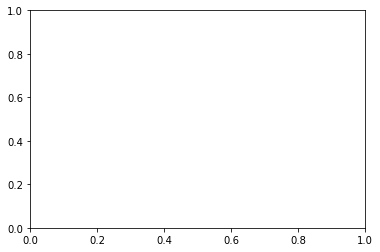

In [20]:
sns.histplot(data=train, x= df[df.age_bin == pd.Interval(0, 40)].logerror)

Text(0.5, 1.0, '120 and up')

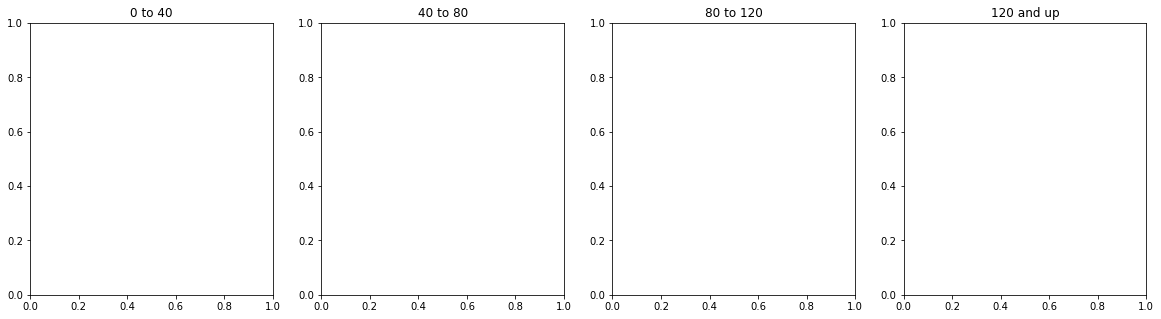

In [21]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(0, 40)].logerror)
plt.title("0 to 40")
plt.subplot(1,4,2)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(40,80)].logerror)
plt.title("40 to 80")
plt.subplot(1,4,3)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(80,120)].logerror)
plt.title("80 to 120")
plt.subplot(1,4,4)
sns.histplot(data=df, x= train[train.age_bin == pd.Interval(120,200)].logerror)
plt.title("120 and up")
# plt.subplot(1,7,5)
# sns.histplot(data=df, x= train[train.age_bin == pd.Interval(80, 100)].logerror)
# plt.title("80 to 100")
# plt.subplot(1,7,6)
# sns.histplot(data=df, x= train[train.age_bin == pd.Interval(100, 120)].logerror)
# plt.title("100 to 120")
# plt.subplot(1,7,7)
# sns.histplot(data=df, x= train[train.age_bin == pd.Interval(120, 200)].logerror)
# plt.title("120 and Up")

Looking at logerror by age_bin, they are generally normally distributed

Maybe run an ANOVA test to see about the variances? 

First, Levene

In [22]:
#H0: Variances are equal
#Ha: Variances are not equal

stats.levene(
    train[train.age_bin == pd.Interval(0, 40)].logerror,
    train[train.age_bin == pd.Interval(40,80)].logerror,
    train[train.age_bin == pd.Interval(80,120)].logerror,
    train[train.age_bin == pd.Interval(120,200)].logerror,
#     train[train.age_bin == pd.Interval(80,100)].logerror,
#     train[train.age_bin == pd.Interval(100,120)].logerror,
#     train[train.age_bin == pd.Interval(120,200)].logerror
)

LeveneResult(statistic=nan, pvalue=nan)

The results show that the null hypothesis is rejected

In [23]:
train[train.age_bin == pd.Interval(0, 40)].logerror.var()

nan

In [24]:
train[train.age_bin == pd.Interval(120,200)].logerror.var()

nan

#### Anova testing of the logerror by age_bin

Set Hypothesis
- 𝐻0 : Population means of logerror (by age_bin) are equal
- 𝐻𝑎 : Population means of logerror (by age_bin) are not all equal

In [25]:
# This cell runs an ANOVA test on the different 'age_bins'
# We are demonstrating statistically that the age correlates to the logerror
f, p = stats.f_oneway(
    train[train.age_bin == pd.Interval(0, 40)].logerror,
    train[train.age_bin == pd.Interval(40,80)].logerror,
    train[train.age_bin == pd.Interval(80,120)].logerror,
    train[train.age_bin == pd.Interval(120,200)].logerror)
          
#     train[train.age_bin == pd.Interval(80,100)].logerror,
#     train[train.age_bin == pd.Interval(100,120)].logerror,
#     train[train.age_bin == pd.Interval(120,200)].logerror
#
f, p

(nan, nan)

In [26]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We fail to reject $H_{0}$


#### The anova test shows I can proceed with the understanding that the average logerror is different depending on the age of the home

In [27]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'condition', 'sq_ft', 'full_baths',
       'latitude', 'longitude', 'lot_size', 'census_tract', 'city_id', 'zip',
       'rooms', 'structure_value', 'tax_value', 'year_assessed', 'land_value',
       'tax_amount', 'logerror', 'county', 'age', 'sq_ft_per_bathroom',
       'sq_ft_per_bedroom', 'sq_ft_per_room', 'has_half_bath', 'age_bin',
       'tax_rate', 'price_per_sq_ft', 'Los_Angeles', 'Orange', 'Ventura'],
      dtype='object')

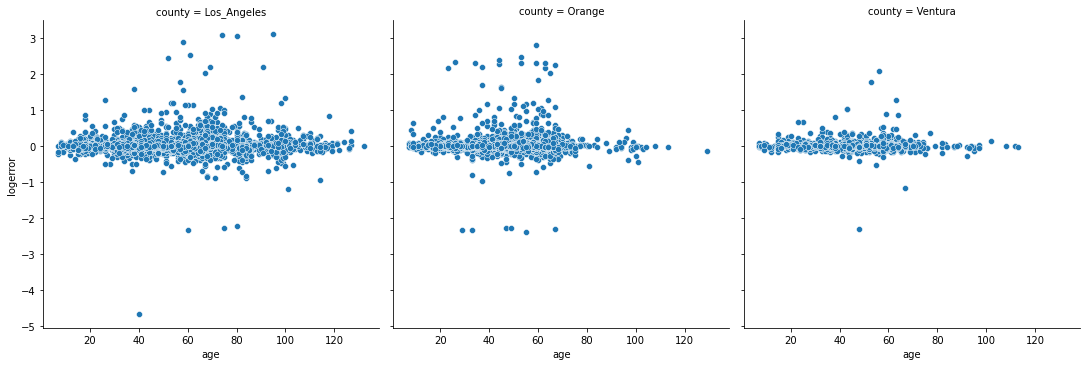

In [28]:
sns.relplot(data=train, y='logerror', x='age', col='county')

This relplot shows age and logerror by county; any dignificant differences between the counties aren't clear

### What about a relationship between tax_value and logerror? (also: are these related targets?)

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

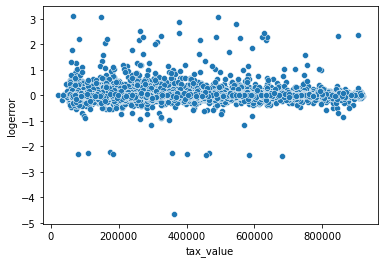

In [29]:
sns.scatterplot(x=train.tax_value, y=train.logerror, data=train)

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

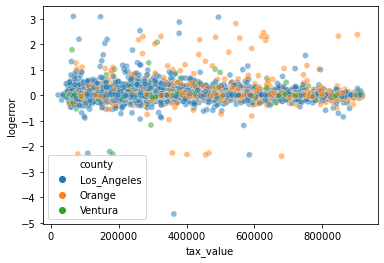

In [30]:
sns.scatterplot(x=train.tax_value, y=train.logerror, data=train, hue='county', alpha=.5)

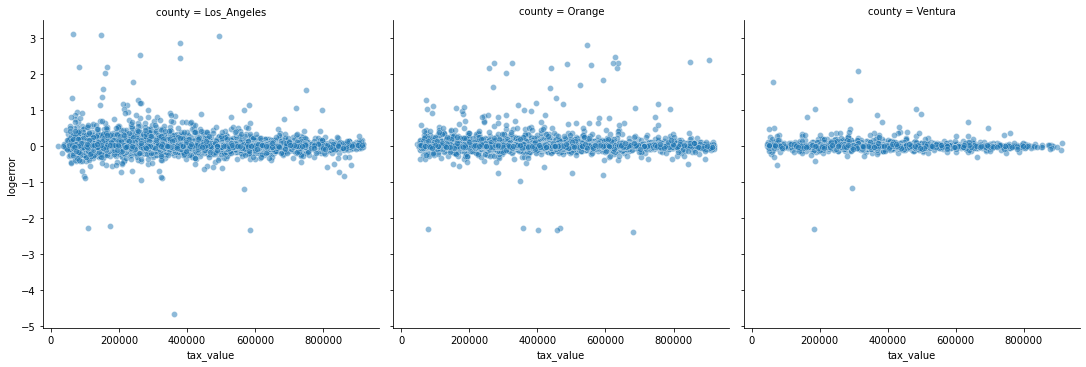

In [31]:
sns.relplot(x=train.tax_value, y=train.logerror, data=train, col='county', alpha=.5)

In [32]:
train[train.county=='Los_Angeles'].shape

(12714, 31)

In [33]:
train[train.county=='Orange'].shape

(7334, 31)

In [34]:
train[train.county=='Ventura'].shape

(2113, 31)

### No clear impressions

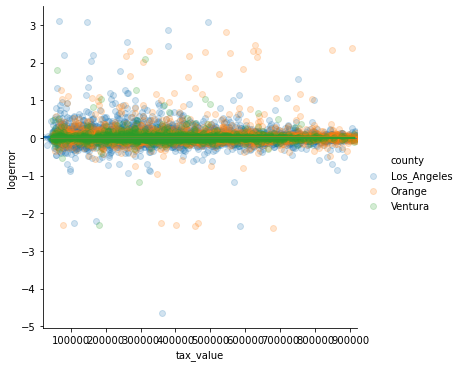

In [35]:
sns.lmplot(x='tax_value', y='logerror', data=train, scatter_kws={'alpha':.2},hue='county')

### Look like perfectly flat trend lines

In [36]:
train.head().T

,16469,41912,68353,64323,71861
parcelid,10841073,14438533,13965242,12577756,12511184
bathrooms,2.0,3.0,2.0,2.0,2.0
bedrooms,2.0,4.0,3.0,3.0,2.0
condition,6.0,6.0,6.0,6.0,8.0
sq_ft,1721.0,2580.0,1288.0,1583.0,1024.0
full_baths,2.0,3.0,2.0,2.0,2.0
latitude,34189309.0,33456409.0,33741136.0,33850296.0,33786721.0
longitude,-118435470.0,-117632929.0,-117979587.0,-118238478.0,-118136304.0
lot_size,8103.0,12191.0,6695.0,5611.0,9923.0
census_tract,60371281.012005,60590421.112011,60590997.021018,60375433.042008,60375749.023001


## Does the condition of the home have an impact on the logerror?

<AxesSubplot:xlabel='condition', ylabel='logerror'>

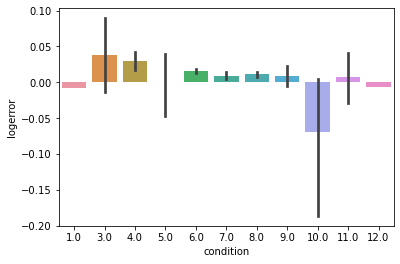

In [37]:
sns.barplot(x=train.condition,y=train.logerror, data=train)

Ok, the logerror is off by more on the houses with a condition of 1 and 3

### An ANOVA test might be in order to show this:

First, a Levene test to check on variances:

#H0: Variances are equal
#Ha: Variances are not equal

<AxesSubplot:>

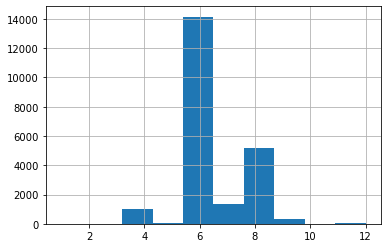

In [38]:
train['condition'].hist()

Roughly normally distributed

In [39]:
# Levene test for equal variances...they aren't equal
stats.levene(train.condition==1,train.condition==3,train.condition==4,train.condition==5,
            train.condition==6,train.condition==7,train.condition==8,train.condition==9,
            train.condition==10, train.condition==11,train.condition==12)

LeveneResult(statistic=6602.5022161121415, pvalue=0.0)

Set Hypothesis (for the ANOVA test)
- 𝐻0 : Population means of logerror (by condition) are equal
- 𝐻𝑎 : Population means of logerror (by condition) are not all equal

In [40]:
# the anova test:
f, p = stats.f_oneway(train.condition==1,train.condition==3,train.condition==4,train.condition==5,
            train.condition==6,train.condition==7,train.condition==8,train.condition==9,
            train.condition==10, train.condition==11,train.condition==12)
f,p

(17326.94526429442, 0.0)

In [41]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

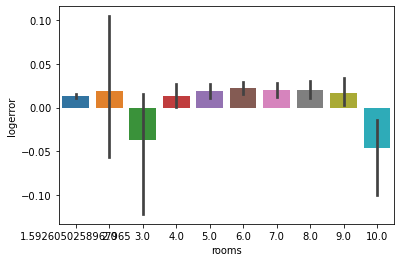

In [42]:
sns.barplot(x=train.rooms,y=train.logerror, data=train)
plt.tight_layout

## OK, let's answer a simple question for now:

## Does (or...how does?) logerror differ by county?

<AxesSubplot:xlabel='county', ylabel='logerror'>

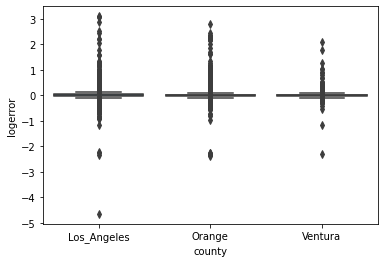

In [43]:
sns.boxplot(x=train.county, y=train.logerror)

<AxesSubplot:xlabel='county', ylabel='logerror'>

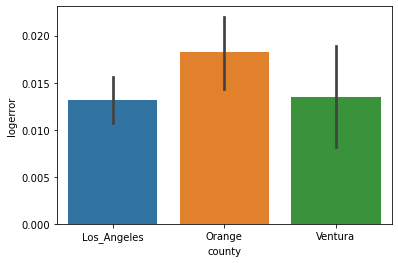

In [44]:
sns.barplot(x=train.county, y=train.logerror)

### Running a nope, also an ANOVA to check on this

H_0: Average logerror of the three counties is the same


H_a: The logerror is different according to county

In [45]:
# Assumptions: independence, yes.  Normal: yes (also large sample). Variances....
train.Orange.var()

0.22142929809531395

In [46]:
train.Los_Angeles.var()

0.24457778788866577

In [47]:
train.Ventura.var()

0.08626039467976152

Definitely different variances, so set that in the test

In [48]:
f,p = scipy.stats.f_oneway(train.Orange,train.Los_Angeles,train.Ventura)
f,p

(6887.2947908608685, 0.0)

In [49]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


And thus, we conclude that the means of the different logerrors by county are different

In [50]:
train.head().T

,16469,41912,68353,64323,71861
parcelid,10841073,14438533,13965242,12577756,12511184
bathrooms,2.0,3.0,2.0,2.0,2.0
bedrooms,2.0,4.0,3.0,3.0,2.0
condition,6.0,6.0,6.0,6.0,8.0
sq_ft,1721.0,2580.0,1288.0,1583.0,1024.0
full_baths,2.0,3.0,2.0,2.0,2.0
latitude,34189309.0,33456409.0,33741136.0,33850296.0,33786721.0
longitude,-118435470.0,-117632929.0,-117979587.0,-118238478.0,-118136304.0
lot_size,8103.0,12191.0,6695.0,5611.0,9923.0
census_tract,60371281.012005,60590421.112011,60590997.021018,60375433.042008,60375749.023001


## Does my whole theory about half bathrooms bear out??

<AxesSubplot:xlabel='has_half_bath', ylabel='logerror'>

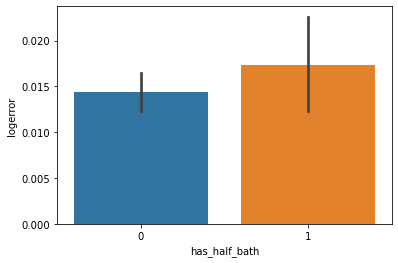

In [51]:
sns.barplot(x=train.has_half_bath,y=train.logerror)

OK, well there is some difference, for what it's worth...proceeding to stats testing via one sided, independent t test

First: assumptions:

- Normally distributed....mmm basically yes and many observations
- Independence: check
- Variances...are almost equal actually


<AxesSubplot:>

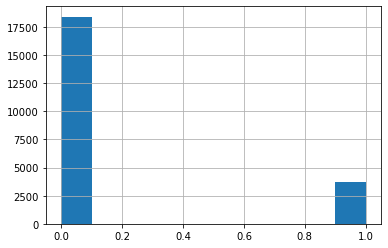

In [52]:
train.has_half_bath.hist()

<AxesSubplot:>

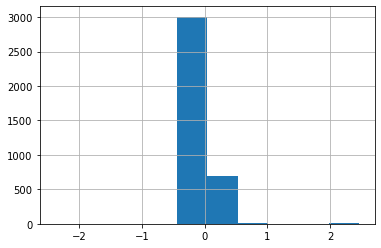

In [53]:
has_half_bath_sample = train[train.has_half_bath == 1].logerror

has_half_bath_sample.hist()

Note how there are some examples that are wildly off in their logerror

In [54]:
has_half_bath_sample.var()

0.024895170440781326

<AxesSubplot:>

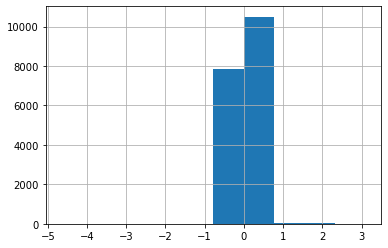

In [55]:
no_half_bath_sample = train[train.has_half_bath==0].logerror
no_half_bath_sample.hist()

In [56]:
no_half_bath_sample.var()

0.020985347019266413

Set Hypothesis

H_0
: Mean of logerror of has_half_bath = Mean of logerror of no_half_bath

H_a
: Mean of logerror of has_half_bath != Mean of logerror of no_half_bath

In [57]:
t, p = stats.ttest_ind(has_half_bath_sample, no_half_bath_sample, equal_var=True)

t, p

(1.1057412938752407, 0.2688505160389922)

p is NOT less than alpha (0.05), and therefore I cannot reject the Null Hypothesis

### So, having a half bathroom does not affect logerror.  Not directly for sure

In [58]:
train.head().T

,16469,41912,68353,64323,71861
parcelid,10841073,14438533,13965242,12577756,12511184
bathrooms,2.0,3.0,2.0,2.0,2.0
bedrooms,2.0,4.0,3.0,3.0,2.0
condition,6.0,6.0,6.0,6.0,8.0
sq_ft,1721.0,2580.0,1288.0,1583.0,1024.0
full_baths,2.0,3.0,2.0,2.0,2.0
latitude,34189309.0,33456409.0,33741136.0,33850296.0,33786721.0
longitude,-118435470.0,-117632929.0,-117979587.0,-118238478.0,-118136304.0
lot_size,8103.0,12191.0,6695.0,5611.0,9923.0
census_tract,60371281.012005,60590421.112011,60590997.021018,60375433.042008,60375749.023001


### I am clustering on the following, so let's do some explo:
sq_ft, price_per_sq_ft, tax_rate

<AxesSubplot:>

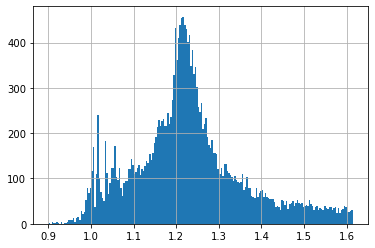

In [59]:
train.tax_rate.hist(bins=200)

In [60]:
train.tax_rate[train.tax_rate > 5].value_counts().sum()

0

### So, I need to deal with a few outliers here.  Tax rates above 5%?? There are all of 38

### Great, all taken care of

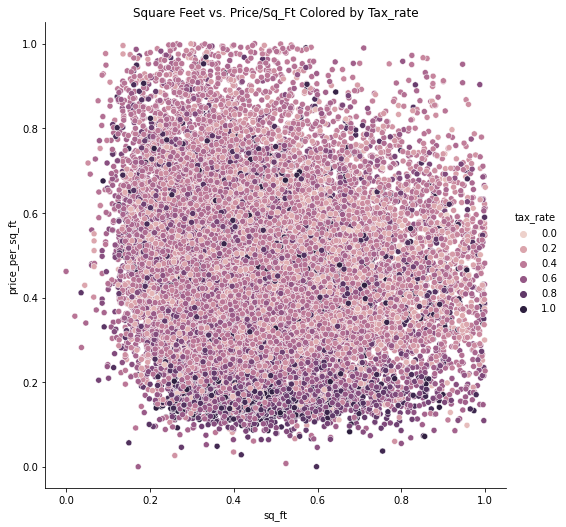

In [61]:
sns.relplot(data=train_scaled, x="sq_ft", y="price_per_sq_ft", hue='tax_rate', height=7, aspect=1).set(title="Square Feet vs. Price/Sq_Ft Colored by Tax_rate")


#### I see more of the higher tax rate homes toward the lower end of the ppsf axis, i think

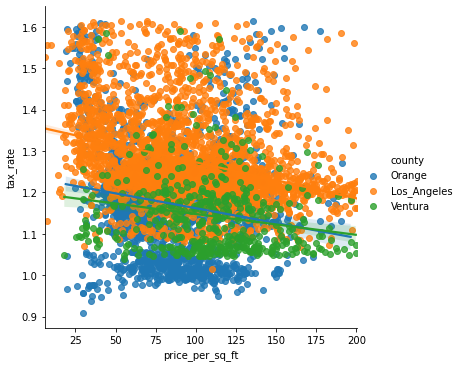

In [68]:
sns.lmplot(x='price_per_sq_ft', y='tax_rate', data=train.sample(5000), hue='county')

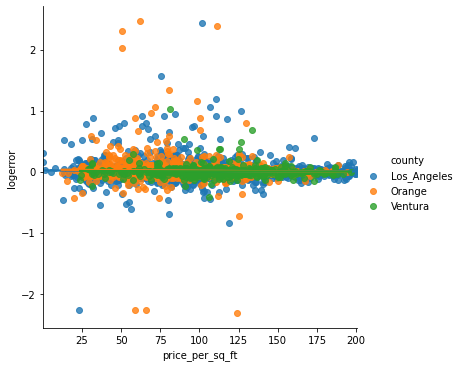

In [69]:
sns.lmplot(x='price_per_sq_ft', y='logerror', data=train.sample(5000), hue='county')

In [72]:
train.logerror[train.price_per_sq_ft == train.price_per_sq_ft.max()]

68412    0.031213
Name: logerror, dtype: float64

In [73]:
train.logerror[train.price_per_sq_ft == train.price_per_sq_ft.min()]

15426    0.156377
Name: logerror, dtype: float64

In [75]:
train.logerror.describe()

count    22161.000000
mean         0.014881
std          0.147125
min         -4.655420
25%         -0.022152
50%          0.005710
75%          0.033633
max          3.100913
Name: logerror, dtype: float64

In [77]:
train.groupby(by='county').logerror.mean()

county
Los_Angeles    0.013150
Orange         0.018299
Ventura        0.013435
Name: logerror, dtype: float64